In [157]:
import glob
import numpy as np
import datetime
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from scipy.signal import butter, filtfilt

import cv2



In [158]:
def set_axis(x: np.ndarray, no_labels: int = 7)->tuple[np.ndarray, np.ndarray]:
    """Sets the x-axis positions and labels for a plot.

    Args:
        x (np.array): The x-axis data.
        no_labels (int, optional): The number of labels to display. Defaults to 7.

    Returns:
        tuple[np.array, np.array]: A tuple containing:
            - The positions of the labels on the x-axis.
            - The labels themselves.
    """
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1)) 
    x_positions = np.arange(0,nx,step_x) 
    x_labels = x[::step_x]
    return x_positions, x_labels

def automedian(img: np.ndarray, struct: np.ndarray) -> np.ndarray:
    img_O = cv2.morphologyEx(img, cv2.MORPH_OPEN, struct)
    img_CO = cv2.morphologyEx(img_O, cv2.MORPH_CLOSE, struct)
    img_OCO = cv2.morphologyEx(img_CO, cv2.MORPH_OPEN, struct)

    img_C = cv2.morphologyEx(img, cv2.MORPH_CLOSE, struct)
    img_OC = cv2.morphologyEx(img_C, cv2.MORPH_OPEN, struct)
    img_COC = cv2.morphologyEx(img_OC, cv2.MORPH_CLOSE, struct)
    img_Q = np.minimum(img, img_COC)

    img_A = np.maximum(img_Q, img_OCO)

    return img_A

def plt_imshow(df: pd.DataFrame, lines=None, norm=None):
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes()
    cax = fig.add_axes((ax.get_position().x1+0.06,ax.get_position().y0,0.02,ax.get_position().height))
    x_positions, x_labels = set_axis(df.columns)
    ax.set_xticks(x_positions, np.round(x_labels))
    y_positions, y_labels = set_axis(df.index.time)
    ax.set_yticks(y_positions, y_labels)
    im = ax.imshow(df,interpolation='none',aspect='auto', norm=norm)
    plt.colorbar(im, cax=cax)

    plt.ylabel('time')
    plt.xlabel('space [m]')

In [159]:
path_out = 'train_data/'
files = glob.glob(path_out+"*")
files.sort()

In [160]:
dx = 5.106500953873407
dt = 0.0016

data = []
my_first_filename = 'train_data/091222.npy'
first_id = 0
for idx, filename in enumerate(files):
    if filename == my_first_filename:
        first_id = idx
first_filename = files[first_id]
for file in files[first_id:first_id+12]:
    data.append(np.load(file))
data = np.concatenate(data).astype(np.float32)
time_start = datetime.datetime.strptime(
    '2024-05-07 ' + first_filename.split("/")[-1].split(".")[0], "%Y-%m-%d %H%M%S")
index = pd.date_range(start=time_start, periods=len(data), freq=f'{dt}s')

columns = np.arange(len(data[0])) * dx

base_df = pd.DataFrame(data=data, index=index, columns=columns)



In [161]:
def plot_fft(df, col_id, dt, xlim=300):
    """Plot FFT spectrum at a spatial position."""
    spatial_pos = df.columns[col_id] 
    signal = df[spatial_pos].values
    fft_result = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(len(signal), d=dt)
    pos_freqs = fft_freqs[:len(signal)//2]
    pos_mags = np.abs(fft_result[:len(signal)//2])
    plt.plot(pos_freqs, pos_mags)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude')
    plt.title(f'Frequency spectrum at {spatial_pos:.1f} m')
    plt.xlim(0, xlim)
    plt.show()

def plot_average_freq_spectrum(filtered_df, dt, col_start=None, col_end=None):
    """
    Plots the average frequency spectrum over selected spatial columns.
    
    Parameters:
      filtered_df: pandas DataFrame, rows=time, cols=space
      dt: time step (seconds)
      col_start: first column index to include (inclusive)
      col_end: last column index to include (exclusive)
      title: custom plot title (optional)
      xlim: x-axis frequency limit for plot (optional, tuple)
    """
    avg_signal = filtered_df.iloc[:, col_start:col_end].mean(axis=1).values
    fft_result = np.fft.fft(avg_signal)
    fft_freqs = np.fft.fftfreq(len(avg_signal), d=dt)
    positive_freqs = fft_freqs[:len(avg_signal)//2]
    positive_mags = np.abs(fft_result[:len(avg_signal)//2])
    
    plt.plot(positive_freqs, positive_mags)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Amplitude")
    title_substring = "all" if col_start is None or col_end is None else f"{col_start} to {col_end-1}"
    plt.title(f"Average Frequency Spectrum for columns: {title_substring}")

    plt.show()

#https://www.geeksforgeeks.org/data-science/signal-filtering-with-scipy/
def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def filter_df_band(df, low, high, dt, order=4):
    fs = 1 / dt
    return df.apply(lambda col: butter_bandpass_filter(col.values, low, high, fs, order), axis=0)

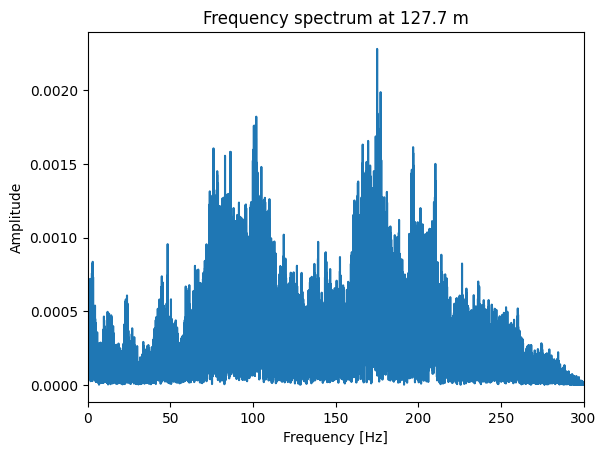

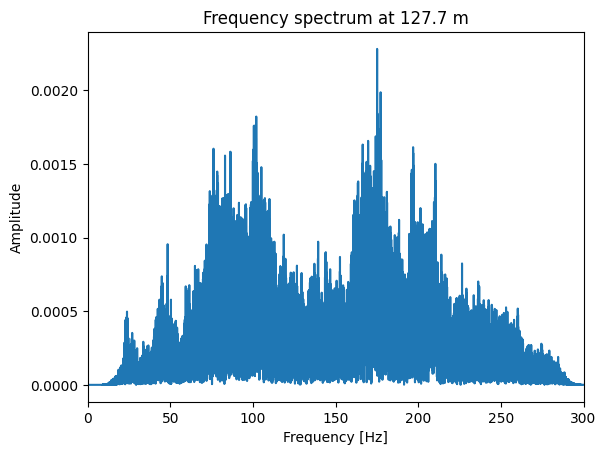

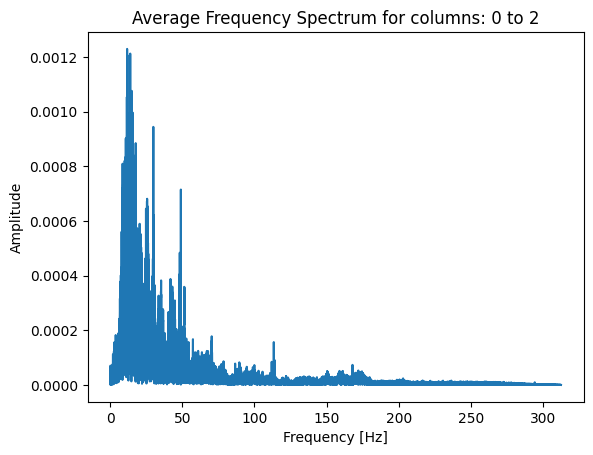

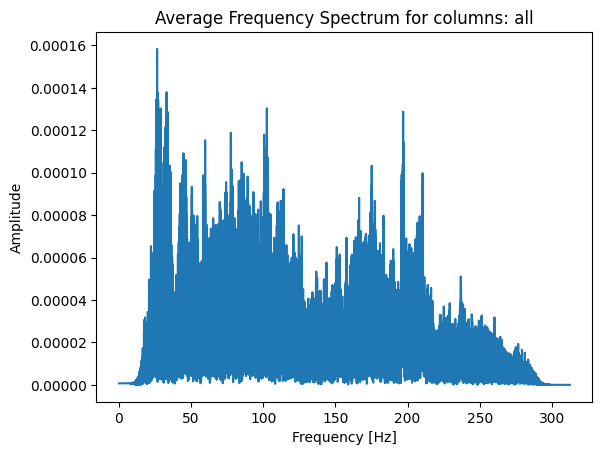

In [162]:
col_id = 25
filtered_df = filter_df_band(base_df, low=20, high=290, dt=dt, order=4)

plot_fft(base_df, col_id, dt)
plot_fft(filtered_df, col_id, dt)
plot_average_freq_spectrum(base_df, dt, col_start=0, col_end=3)
plot_average_freq_spectrum(filtered_df, dt)



In [163]:
def preprocess_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.iloc[::10, :]  # Every 10th time sample, all columns
    data = df.to_numpy(dtype=np.float32)
    data = (data - data.mean()) / data.std()
    # data = cv2.resize(data, dsize=(52, 750), interpolation=cv2.INTER_AREA)
    data = cv2.bilateralFilter(data, 9, 75, 75)
    # data = cv2.GaussianBlur(data,(5,5),cv2.BORDER_DEFAULT)
    processed_df = pd.DataFrame(data, index=df.index, columns=df.columns)
    return processed_df

base_df -= base_df.mean()
base_df = np.abs(base_df)

filtered_df -= filtered_df.mean()
filtered_df = np.abs(filtered_df)

dfs = [base_df, filtered_df]
pp_dfs = [preprocess_df(df) for df in dfs]
all_dfs = dfs + pp_dfs

norms = []
for df in all_dfs:
    low, high = np.percentile(df, [3, 99])
    norms.append(Normalize(vmin=low, vmax=high, clip=True))




# data = cv2.normalize(data, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
# data = cv2.bilateralFilter(data, 9, 100, 100) #https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html

# data = cv2.resize(data, (1000, data.shape[0]), interpolation=cv2.INTER_CUBIC)
# _, th = cv2.threshold(data, 0, 255, cv2.THRESH_OTSU)
# th[th > 0] = 255
# edges = cv2.Canny(th, 5, 20)
# lines = cv2.HoughLines(edges, 1, np.pi / 180, 150, None, 0, 0)
# edges = cv2.Canny(data_8bit, threshold1=50, threshold2=150, L2gradient=True)


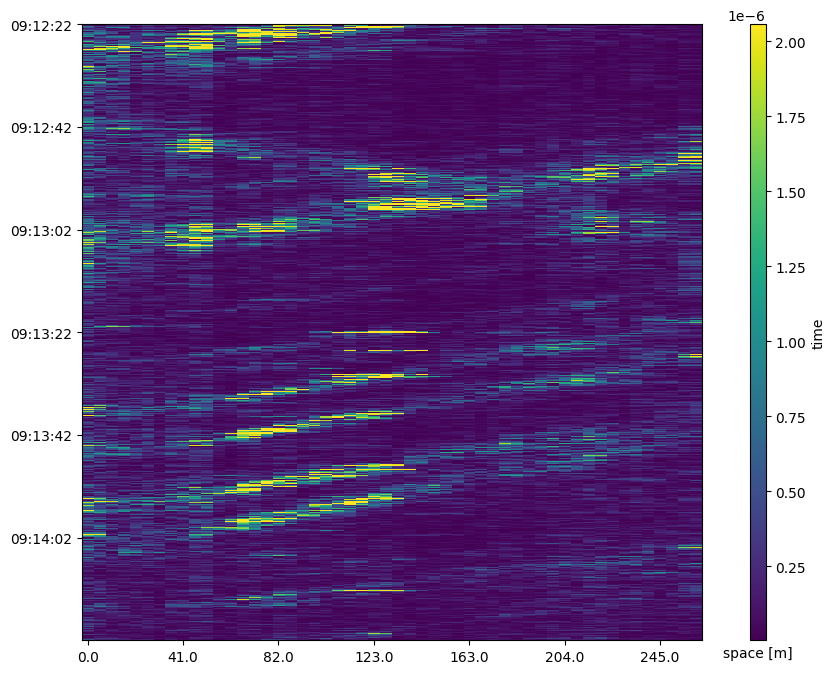

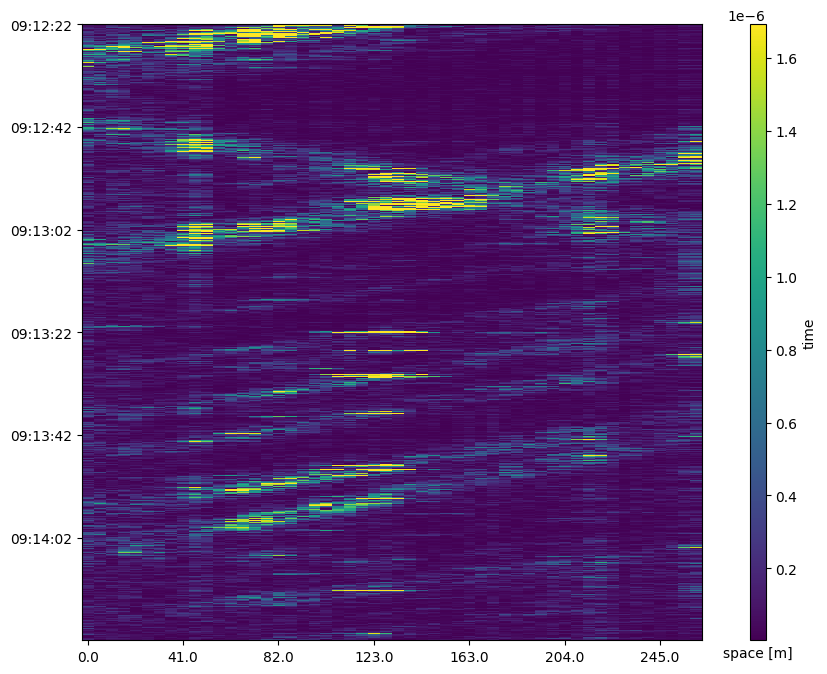

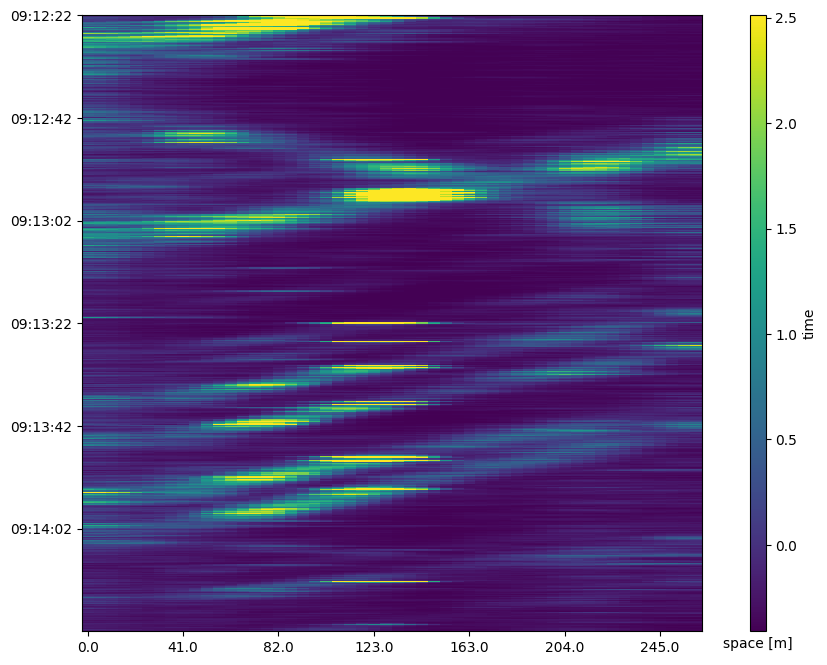

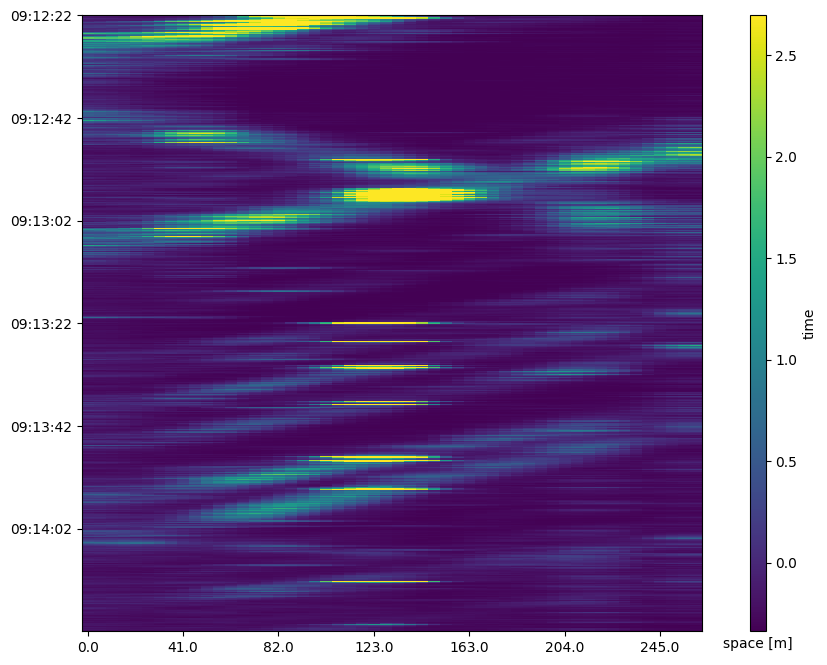

In [164]:
for df, norm in zip(all_dfs, norms):
    plt_imshow(df, lines=None, norm=norm)

In [165]:
#https://stackoverflow.com/questions/71425968/remove-horizontal-lines-with-open-cv possibly interesting
# https://docs.opencv.org/3.2.0/d1/dee/tutorial_moprh_lines_detection.html